Number of 'lie' samples: 65
Number of 'truth' samples: 78
Total number of samples: 143
Adding 5 lie samples from subject 8 to test set
Adding 6 truth samples from subject 8 to test set
Adding 5 lie samples and 6 truth samples from subject 7 to train set
Adding 5 lie samples and 6 truth samples from subject 3 to train set
Adding 5 lie samples and 6 truth samples from subject 10 to train set
Adding 5 lie samples and 6 truth samples from subject 13 to train set
Adding 5 lie samples and 6 truth samples from subject 6 to train set
Adding 5 lie samples and 6 truth samples from subject 12 to train set
Adding 5 lie samples and 6 truth samples from subject 9 to train set
Adding 5 lie samples and 6 truth samples from subject 4 to train set
Adding 5 lie samples and 6 truth samples from subject 5 to train set
Adding 5 lie samples and 6 truth samples from subject 1 to train set
Adding 5 lie samples and 6 truth samples from subject 2 to train set
Adding 5 lie samples and 6 truth samples from subject

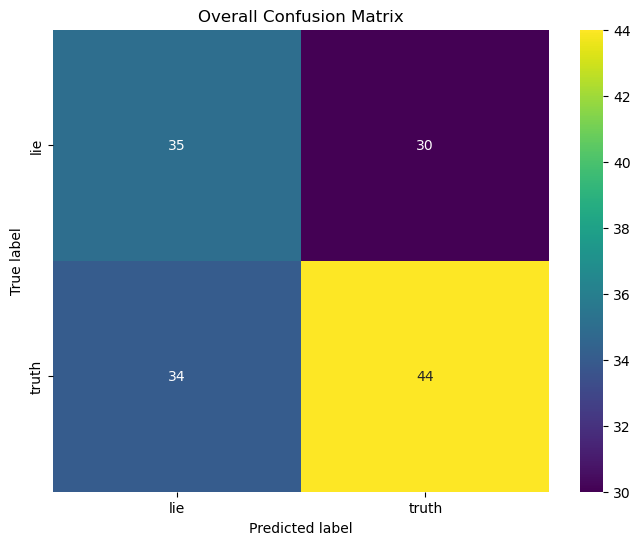

In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import random
import seaborn as sns


model_save_dir = r'C:\Users\User\Documents\Lie detect data\Model'
os.makedirs(model_save_dir, exist_ok=True)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['lie', 'truth'], yticklabels=['lie', 'truth'])
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Define a function to load and pad data
def load_data(data_dir, max_length):
    subject_data = {'lie': {}, 'truth': {}}
    
    file_list = os.listdir(data_dir)
    
    for file in file_list:
        with open(os.path.join(data_dir, file), 'rb') as f:
            data = pickle.load(f)
        
        # Determine if the file is 'truth' or 'lie'
        label_type = 'truth' if 'truth' in file else 'lie'
        subj_id = int(file.split('_')[-1].split('.')[0])
        
        # Grouping logic
        if label_type == 'lie':
            # Mapping each 5 lie samples to one subject
            subject_key = (subj_id - 1) // 5 + 1
        else:  # 'truth'
            # Mapping each 6 truth samples to one subject
            subject_key = (subj_id - 1) // 6 + 1
        
        # Initialize the subject's list if it doesn't exist
        if subject_key not in subject_data[label_type]:
            subject_data[label_type][subject_key] = []
        
        # Pad or truncate the data to match max_length
        if data.shape[1] > max_length:
            processed_data = data[:, :max_length]  # Truncate if it exceeds max_length
        else:
            processed_data = np.zeros((data.shape[0], max_length))
            processed_data[:, :data.shape[1]] = data  # Pad if it is shorter than max_length
        
        # Add the processed data to the appropriate list
        subject_data[label_type][subject_key].append(processed_data)
    
    return subject_data

# Load dataset and pad/truncate the data
data_dir = "C:\\Users\\User\\Documents\\Lie detect data\\7M_EEGData"
max_length = 3750 # Define maximum length for padding
subject_data = load_data(data_dir, max_length)

# Count the total number of samples
num_lie_samples = sum(len(subject_data['lie'][subject_key]) for subject_key in subject_data['lie'])
num_truth_samples = sum(len(subject_data['truth'][subject_key]) for subject_key in subject_data['truth'])

print(f"Number of 'lie' samples: {num_lie_samples}")
print(f"Number of 'truth' samples: {num_truth_samples}")
print(f"Total number of samples: {num_lie_samples + num_truth_samples}")


# Define dataset class
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Ensure the data is reshaped to [1, Chans, Samples]
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# Define EEGNet model
class SeparableConv2d(nn.Module):
    def __init__(self, c_in: int, c_out: int, kernel_size: tuple, padding: tuple = 0):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.kernel_size = kernel_size
        self.padding = padding
        self.depthwise_conv = nn.Conv2d(self.c_in, self.c_in, kernel_size=self.kernel_size,
                                        padding=self.padding, groups=self.c_in)
        self.conv2d_1x1 = nn.Conv2d(self.c_in, self.c_out, kernel_size=1)

    def forward(self, x: torch.Tensor):
        y = self.depthwise_conv(x)
        y = self.conv2d_1x1(y)
        return y

class SeparableConv1d(nn.Module):
    def __init__(self, c_in: int, c_out: int, kernel_size: tuple, padding: tuple = 0):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.kernel_size = kernel_size
        self.padding = padding
        self.depthwise_conv = nn.Conv1d(self.c_in, self.c_in, kernel_size=self.kernel_size,
                                        padding=self.padding, groups=self.c_in)
        self.conv1d_1x1 = nn.Conv1d(self.c_in, self.c_out, kernel_size=1)

    def forward(self, x: torch.Tensor):
        y = self.depthwise_conv(x)
        y = self.conv1d_1x1(y)
        return y

class EEGNet(nn.Module):
    def __init__(self, nb_classes: int = 2, Chans: int = 65, Samples: int = 3750,
                 dropoutRate: float = 0.7, kernLength: int = 63,
                 F1:int = 8, D:int = 2):
        super().__init__()

        F2 = F1 * D

        # Make kernel size and odd number
        try:
            assert kernLength % 2 != 0
        except AssertionError:
            raise ValueError("ERROR: kernLength must be odd number")

        # In: (B, Chans, Samples, 1)
        # Out: (B, F1, Samples, 1)
        self.conv1 = nn.Conv1d(Chans, F1, kernLength, padding=(kernLength // 2))
        self.bn1 = nn.BatchNorm1d(F1) # (B, F1, Samples, 1)
        # In: (B, F1, Samples, 1)
        # Out: (B, F2, Samples - Chans + 1, 1)
        self.conv2 = nn.Conv1d(F1, F2, Chans, groups=F1)
        self.bn2 = nn.BatchNorm1d(F2) # (B, F2, Samples - Chans + 1, 1)
        # In: (B, F2, Samples - Chans + 1, 1)
        # Out: (B, F2, (Samples - Chans + 1) / 4, 1)
        self.avg_pool = nn.AvgPool1d(4)
        self.dropout = nn.Dropout(dropoutRate)

        # In: (B, F2, (Samples - Chans + 1) / 4, 1)
        # Out: (B, F2, (Samples - Chans + 1) / 4, 1)
        self.conv3 = SeparableConv1d(F2, F2, kernel_size=31, padding=15)
        self.bn3 = nn.BatchNorm1d(F2)
        # In: (B, F2, (Samples - Chans + 1) / 4, 1)
        # Out: (B, F2, (Samples - Chans + 1) / 32, 1)
        self.avg_pool2 = nn.AvgPool1d(8)
        # In: (B, F2 *  (Samples - Chans + 1) / 32)
        self.fc = nn.Linear(F2 * ((Samples - Chans + 1) // 32), nb_classes)

    def forward(self, x: torch.Tensor):
        # Block 1
        y1 = self.conv1(x)
        #print("conv1: ", y1.shape)
        y1 = self.bn1(y1)
        #print("bn1: ", y1.shape)
        y1 = self.conv2(y1)
        #print("conv2", y1.shape)
        y1 = F.elu(self.bn2(y1))
        #print("bn2", y1.shape)
        y1 = self.avg_pool(y1)
        #print("avg_pool", y1.shape)
        y1 = self.dropout(y1)
        #print("dropout", y1.shape)

        # Block 2
        y2 = self.conv3(y1)
        #print("conv3", y2.shape)
        y2 = F.elu(self.bn3(y2))
        #print("bn3", y2.shape)
        y2 = self.avg_pool2(y2)
        #print("avg_pool2", y2.shape)
        y2 = self.dropout(y2)
        #print("dropout", y2.shape)
        y2 = torch.flatten(y2, 1)
        #print("flatten", y2.shape)
        y2 = self.fc(y2)
        #print("fc", y2.shape)

        return y2



# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_and_evaluate(train_loader, val_loader, y_train):
    model = EEGNet().to(device)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

    num_epochs = 200
    best_val_loss = float('inf')
    patience = 200
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            fold_model_path = os.path.join(model_save_dir, f'revise_model_fold_{fold_idx}.pth')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': best_val_loss,
            }, fold_model_path)
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

        print(f'Epoch {epoch}: Train Loss: {avg_train_loss}, Validation Loss: {val_loss}')

    return model

# Set a random seed for reproducibility
random.seed(42)

# Initialize the cross-validation
subject_ids = list(range(1, 14))  # Since there are 13 subjects for lie and truth
random.shuffle(subject_ids)  # Shuffle to ensure random selection

# Initialize arrays to store all labels, predictions, and metrics
all_labels = []
all_predictions = []

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_aucs = []
fold_conf_matrices = []

for fold_idx in range(13):
    # Split subjects into test and training sets
    test_subject = subject_ids[fold_idx]

    # Prepare training and test data
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for subject_id in subject_ids:
        lie_samples = subject_data['lie'].get(subject_id, [])
        truth_samples = subject_data['truth'].get(subject_id, [])

        if subject_id == test_subject:
            X_test.extend(lie_samples)
            y_test.extend([0] * len(lie_samples))
            print(f"Adding {len(lie_samples)} lie samples from subject {subject_id} to test set")
            X_test.extend(truth_samples)
            y_test.extend([1] * len(truth_samples))
            print(f"Adding {len(truth_samples)} truth samples from subject {subject_id} to test set")
        else:
            X_train.extend(lie_samples)
            y_train.extend([0] * len(lie_samples))
            X_train.extend(truth_samples)
            y_train.extend([1] * len(truth_samples))
            print(f"Adding {len(lie_samples)} lie samples and {len(truth_samples)} truth samples from subject {subject_id} to train set")

    print(f"Total training samples: {len(X_train)}, Total test samples: {len(X_test)}")
    
    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Normalize data using scaler fitted on training data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))
    X_train = X_train.reshape(-1, 65, max_length)
    X_test = X_test.reshape(-1, 65, max_length)

    print(X_test.shape)
    print(X_train.shape)

    # Save the scaler to a file
    with open(r'C:\Users\User\Documents\Lie detect data\Model\RevisedEEGNet_scaler_{}.pkl'.format(fold_idx), 'wb') as f:
        pickle.dump(scaler, f)

    # Create datasets and dataloaders
    train_dataset = EEGDataset(X_train, y_train)
    test_dataset = EEGDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train and evaluate the model
    model = train_and_evaluate(train_loader, test_loader, y_train)

    # Evaluate on the test set and calculate metrics
    model.eval()
    fold_labels = []
    fold_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            fold_labels.extend(y_batch.cpu().numpy())
            fold_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics for the current fold
    accuracy = accuracy_score(fold_labels, fold_predictions)
    precision = precision_score(fold_labels, fold_predictions)
    recall = recall_score(fold_labels, fold_predictions)
    f1 = f1_score(fold_labels, fold_predictions)
    auc = roc_auc_score(fold_labels, fold_predictions)
    conf_matrix = confusion_matrix(fold_labels, fold_predictions)

    # Store fold metrics
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_aucs.append(auc)
    fold_conf_matrices.append(conf_matrix)

    # Print metrics for the current fold
    print(f'Fold {fold_idx + 1} Metrics:')
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}, AUC: {auc}')
    print('Confusion Matrix:')
    print(conf_matrix)

    # Aggregate all labels and predictions for final evaluation across all folds
    all_labels.extend(fold_labels)
    all_predictions.extend(fold_predictions)

    print(f'Completed fold {fold_idx + 1}')
    print('-' * 50)

# Calculate overall metrics across all folds
overall_accuracy = accuracy_score(all_labels, all_predictions)
overall_precision = precision_score(all_labels, all_predictions)
overall_recall = recall_score(all_labels, all_predictions)
overall_f1 = f1_score(all_labels, all_predictions)
overall_auc = roc_auc_score(all_labels, all_predictions)
overall_conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Overall Metrics:')
print(f'Accuracy: {overall_accuracy}, Precision: {overall_precision}, Recall: {overall_recall}, F1-score: {overall_f1}, AUC: {overall_auc}')
print('Overall Confusion Matrix:')
print(overall_conf_matrix)

plot_confusion_matrix(overall_conf_matrix, title='Overall Confusion Matrix')
